# Trabalho de Aprendizagem de máquina
## Qual é o jogador mais superfaturado na NBA de 1999 a 2023?

Aluno: Paulo Roberto Mesquita da Silva <br />
Matricula: 2317078 <br />

Disciplina: INTRODUÇÃO A APRENDIZAGEM DE MAQUINA <br />
Professor: ERNESON ALVES DE OLIVEIRA <br />


In [1]:
# importar bibliotecas

import numpy as npy
import pandas as pd
import locale
import matplotlib.pyplot as plot

from sklearn.model_selection import train_test_split
from num2words import num2words
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# importar dados e parametros dos ambientes

initDate = datetime(1970, 1, 1)
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' )
data = pd.read_csv( 'nba_stats.csv' )
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8162 entries, 0 to 8161
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              8162 non-null   int64  
 1   name                              8162 non-null   object 
 2   playerId                          8162 non-null   int64  
 3   playerSlug                        8162 non-null   object 
 4   positionId                        8156 non-null   object 
 5   teamId                            8162 non-null   object 
 6   status                            8162 non-null   object 
 7   gamesPlayed                       8162 non-null   float64
 8   avgMinutes                        8162 non-null   float64
 9   avgFouls                          8162 non-null   float64
 10  flagrantFouls                     8162 non-null   float64
 11  technicalFouls                    8162 non-null   float64
 12  ejecti

In [3]:
# Padronização das colunas com dados incoerente ou ausentes. 8155 entries
df = data.copy()
df.drop(columns=['college', 'draftinfo', 'birthplace', 'team', 'htwt', 'experience'], inplace=True)
df['salary'] = df['salary'].apply(lambda x: locale.atoi(x[1:]))
df.dropna(subset=['positionId'], inplace=True)

# Apagar o(s) dado(s) com GF (Guard-Forward) .: 1 Resultado (Desconsiderar) 
df = df[~(df['positionId'].eq('GF'))] 
# (8155 entries)

df['birthdate'] = df['birthdate'].apply(lambda i: i[:-5] if len(i) > 10 else i)
df['birthdate_locale'] = df.apply(lambda i: (datetime.strptime(i.birthdate, '%m/%d/%Y') - initDate).total_seconds(), axis=1)
df['salary_description'] = df.apply(lambda i: num2words(i.salary, lang='pt-br'), axis=1)

# Resultado dos dados padronizados (Posição)
df['positionId'].value_counts()

positionId
C     1530
PF    1422
SG    1261
PG    1214
SF    1191
G      786
F      751
Name: count, dtype: int64

In [4]:
# Resultado dos dados padronizados Geral
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 8155 entries, 0 to 8161
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              8155 non-null   int64  
 1   name                              8155 non-null   object 
 2   playerId                          8155 non-null   int64  
 3   playerSlug                        8155 non-null   object 
 4   positionId                        8155 non-null   object 
 5   teamId                            8155 non-null   object 
 6   status                            8155 non-null   object 
 7   gamesPlayed                       8155 non-null   float64
 8   avgMinutes                        8155 non-null   float64
 9   avgFouls                          8155 non-null   float64
 10  flagrantFouls                     8155 non-null   float64
 11  technicalFouls                    8155 non-null   float64
 12  ejections  

,year,name,playerId,playerSlug,positionId,teamId,status,gamesPlayed,avgMinutes,avgFouls,...,avgSteals,avgBlocks,steals,blocks,position,birthdate,rankingSalary,salary,birthdate_locale,salary_description
0,1999,Allen Iverson,366,allen-iverson,SG,PHI,inactive,48.0,41.458332,2.041667,...,2.291667,0.145833,110.0,7.0,Shooting Guard,6/7/1975,15,9000000,1.713312e+08,nove milhões
1,2000,Allen Iverson,366,allen-iverson,SG,PHI,inactive,70.0,40.757140,2.314286,...,2.057143,0.071429,144.0,5.0,Shooting Guard,6/7/1975,27,10125000,1.713312e+08,dez milhões cento e vinte e cinco mil
2,2001,Allen Iverson,366,allen-iverson,SG,PHI,inactive,71.0,41.957745,2.070423,...,2.507042,0.281690,178.0,20.0,Shooting Guard,6/7/1975,17,11250000,1.713312e+08,onze milhões duzentos e cinquenta mil
3,2002,Allen Iverson,366,allen-iverson,SG,PHI,inactive,60.0,43.700000,1.700000,...,2.800000,0.216667,168.0,13.0,Shooting Guard,6/7/1975,14,12375000,1.713312e+08,doze milhões trezentos e setenta e cinco mil
4,2003,Allen Iverson,366,allen-iverson,SG,PHI,inactive,82.0,42.500000,1.817073,...,2.743902,0.158537,225.0,13.0,Shooting Guard,6/7/1975,11,13500000,1.713312e+08,treze milhões e quinhentos mil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8157,2023,Peyton Watson,4576087,peyton-watson,F,DEN,active,23.0,8.086957,0.608696,...,0.086957,0.478261,2.0,11.0,Forward,9/11/2002,277,2303520,1.031702e+09,dois milhões trezentos e três mil quinhentos e...
8158,2023,Josh Minott,4687718,josh-minott,F,MIN,active,15.0,6.400000,0.666667,...,0.266667,0.400000,4.0,6.0,Forward,7/25/2002,332,1719864,1.027555e+09,um milhão setecentos e dezanove mil oitocentos...
8159,2023,Dalen Terry,4433159,dalen-terry,F,CHI,active,38.0,5.631579,0.631579,...,0.289474,0.131579,11.0,5.0,Forward,7/12/2002,238,3350760,1.026432e+09,três milhões trezentos e cinquenta mil setecen...
8160,2023,Ryan Rollins,4591725,ryan-rollins,G,GS,active,12.0,5.166666,0.833333,...,0.083333,0.083333,1.0,1.0,Guard,7/3/2002,334,1719864,1.025654e+09,um milhão setecentos e dezanove mil oitocentos...


### Conjunto de treinamento e conjunto de teste
![picture](https://drive.google.com/thumbnail?id=1m9GfHWwCJKQxewk3-T07-C0Ww5DhALcG&sz=w600)

In [5]:
# Aplicação do conjunto sobre o estudo da coluna ID da posição (positionId)
train_set, test_set = train_test_split(df, test_size=0.2, random_state=43, stratify=df['positionId'])
print('Resultado do Training: ' + str(len(train_set)), 'Test: '+str(len(test_set)))
train_set_label = train_set['salary'].copy()
train_set.drop('salary', axis=1, inplace=True)
test_set_label = test_set['salary'].copy()
test_set.drop('salary', axis=1, inplace=True)
columns_num = list(train_set.select_dtypes(include=[npy.number]))
columns_cat = list(train_set.select_dtypes(exclude=[npy.number]))

Resultado do Training: 6524 Test: 1631


In [6]:
# Pipelines de Transformação
num_pipeline = Pipeline([('Standard_Scaler', StandardScaler())])
cat_pipeline = Pipeline([('OneHot_Encoder', OneHotEncoder())])
pipeline = ColumnTransformer([
    ('num', num_pipeline, columns_num),
    ('cat', cat_pipeline, ['positionId'])
])


In [7]:
# Treinando modelo usando regressão linear (RL)
train_set_prepared = pipeline.fit_transform(train_set)
test_set_prepared = pipeline.fit_transform(test_set)
linReg = LinearRegression()
linReg.fit(train_set_prepared, train_set_label)
rforestReg = RandomForestRegressor()
rforestReg.fit(train_set_prepared, train_set_label)

RandomForestRegressor()

In [8]:
# Resultados RL e RF (Regressão Linear e Floresta aleatoria)
# Conjunto de validação

predicts = linReg.predict(train_set_prepared)
print('Regressão Linear: ', mean_squared_error(train_set_label, predicts, squared=False))

predicts = rforestReg.predict(train_set_prepared)
print('Floresta Aleatória: ', mean_squared_error(train_set_label, predicts, squared=False))

Regressão Linear:  3345330.9502760544
Floresta Aleatória:  155956.81304808933


In [9]:
# Aplicação do modelo e resultado do treinamento (Machine Learning)

predicts = rforestReg.predict(test_set_prepared)
test_set['salary'] = test_set_label.copy()
test_set['predict'] = predicts
test_set['diff'] = predicts - test_set_label

#Exibir resultado
player = test_set.sort_values(by='diff', ascending=False).iloc[0]['name']
print(player)

Kobe Bryant


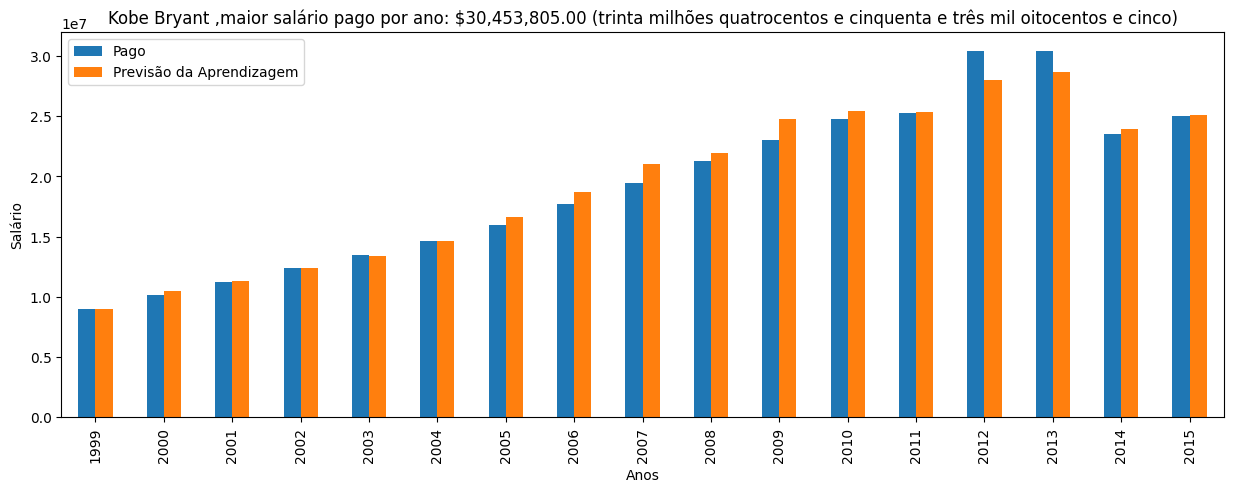

In [14]:
# Jogador com maior sálario e qual foi o ano. (Analise baseada norteada pela a Machine Learning)
#jogadorReferencia = 'Kobe Bryant'
jogadorReferencia = player
anoReferencia = 2013



dfx_label = df['salary'].copy()
dfx = df.drop('salary', axis=1)
dfx_prepared = pipeline.fit_transform(dfx)
predicts = rforestReg.predict(dfx_prepared)

dfx['salary'] = dfx_label.copy()
dfx['predict'] = predicts
dfx['diff'] = predicts - dfx_label

testDescricaoValor = dfx[(dfx['name'] == jogadorReferencia) & (dfx['year'] == anoReferencia)]['salary_description']
descricao_valor = testDescricaoValor.values[0] if(testDescricaoValor.size > 0 ) else 'Dados inconclusível'

gr = dfx[dfx['name'] == jogadorReferencia].sort_values(by='year')[['year', 'salary', 'predict']]

testSalario = gr[gr['year'] == anoReferencia]['salary']
salario = testSalario.values[0] if(testSalario.size > 0 ) else 0

titlePlot = ''
if(salario > 0) : 
     titlePlot = jogadorReferencia +' ,maior salário pago por ano: ' + '${:,.2f}'.format(salario) + ' (' + descricao_valor + ')'

gr.plot(kind='bar', x='year', figsize=(15,5), title=titlePlot)
plot.ylabel('Salário', fontsize=10)
plot.xlabel('Anos', fontsize=10)
plot.legend(['Pago', 'Previsão da Aprendizagem'], fontsize=10)
plot.show()




In [11]:
# Analise dos atributos para busca dos abaixo da média e os acimas da média.

df1 = df.copy()
columns_model = ['gamesPlayed', 'avgMinutes', 'avgFouls', 'flagrantFouls', 'technicalFouls', 'ejections', 'doubleDouble', 'tripleDouble', 'minutes', 'rebounds', 'fouls', 'avgRebounds', 'avgPoints', 'avgFieldGoalsMade', 'avgFieldGoalsAttempted', 'fieldGoalPct', 'avgThreePointFieldGoalsMade', 'avgThreePointFieldGoalsAttempted', 'threePointFieldGoalPct', 'avgFreeThrowsMade', 'avgFreeThrowsAttempted', 'freeThrowPct', 'avgAssists', 'avgTurnovers', 'points', 'fieldGoalsMade', 'fieldGoalsAttempted', 'threePointFieldGoalsMade', 'threePointFieldGoalsAttempted', 'freeThrowsMade', 'freeThrowsAttempted', 'assists', 'turnovers', 'avgSteals', 'avgBlocks', 'steals', 'blocks']
df2 = df1[columns_model].copy()
mean = df2.describe().loc['mean']
df2['model_x'] = 0
for c in columns_model:
    df2['model_x'] = df2.apply(lambda row: row.model_x + 1 if row[c] > mean[c] else row.model_x, axis=1)
    
df['model_x'] = df2['model_x'].copy()

#Jagador Abaixo da média com salário acima da média
playerAM = df[df['model_x'] < df['model_x'].mean()].sort_values(by='salary', ascending=False).iloc[0]['name']
playerAM

'Kevin Love'

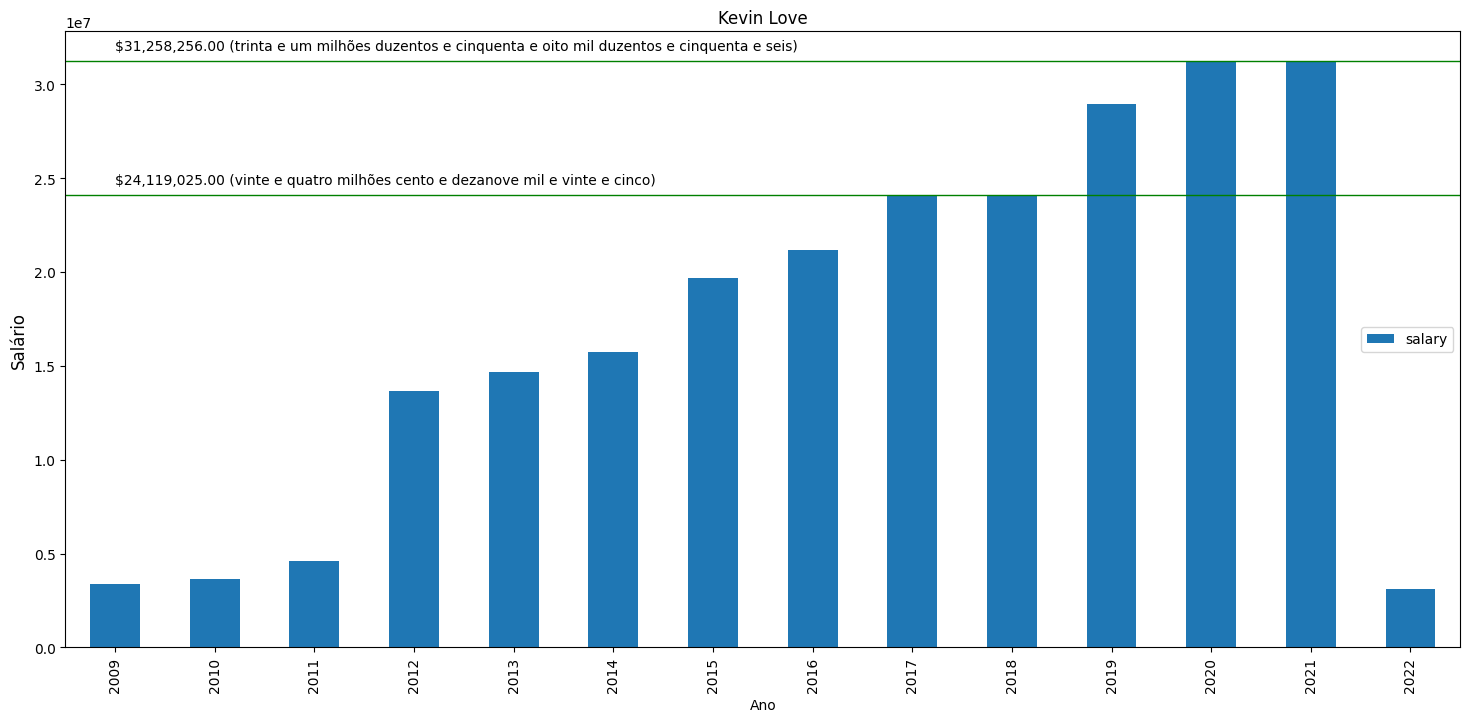

In [12]:
gr = df[df['name'] == playerAM].sort_values(by='year')[['year', 'salary']]
ax = gr.plot.bar(x='year', y='salary', figsize=(18,8), title=playerAM)
plot.ylabel('Salário', fontsize=12)
plot.xlabel('Ano')

# Observações Em 2020
salary = gr[gr['year'] == 2020]['salary'].values[0]
ax.axhline(y=salary, color= 'green', linewidth=1,)
ax.text(x= 0, y=salary + 555550, s='${:,.2f} '.format(salary) + '(' + num2words(salary, lang='pt-br') + ')')

# Observações Em 2017
salary = gr[gr['year'] == 2017]['salary'].values[0]
ax.axhline(y=salary, color= 'green', linewidth=1,)
ax.text(x= 0, y=salary + 555550, s='${:,.2f} '.format(salary) + '(' + num2words(salary, lang='pt-br') + ')')
plot.show()